In [2]:
import os, sys
import pandas as pd
import scipy.stats as stat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# load the template file
template_file = open('../template_script/piano_template.R', 'r')
template_file_info = template_file.read()
template_file.close()
template_file_info

'# Load piano and example data:\nlibrary(piano)\n\npval_table <- read.table(\'PVAL_FILE\')\npvals <- setNames(pval_table$V2,pval_table$V1)\nabs_pvals <- unlist(lapply(pvals, abs))\noriginal_pval <- unlist(lapply(abs_pvals, function(i) 10^(-i)))\n\ndirections <- lapply(pval_table$V2, sign)\ndirections <- unlist(directions)\ndirections <- setNames(directions,pval_table$V1)\n\ntval_table <- read.table(\'TVAL_FILE\')\ntvals <- setNames(pval_table$V2,pval_table$V1)\n\n\npathways <- loadGSC(\'PATHWAY_FILE\')\n\n# Run gene-set analysis:\ngsares_1 <- runGSA(geneLevelStats=original_pval,\n                 directions = directions, \n                 gsc = pathways, geneSetStat="mean")\n\ngsares_2 <- runGSA(geneLevelStats=original_pval,\n                 directions = directions,\n                 gsc = pathways, geneSetStat="median")\n\ngsares_3 <- runGSA(geneLevelStats=original_pval,\n                   directions = directions,\n                   gsc = pathways, geneSetStat="sum")\n\ngsares_5 <

In order to run all underlying methods, PIANO requires two types of information as input:
- P-value for each gene
- fold change for each gene

In [40]:
# change the directory accordingly, if needed
pval_data_dir = '../data/prerank_DESeq2/'
all_pval_data_file = os.listdir(pval_data_dir)
all_pval_data_file.sort()
# to show an example, here we're using first 3 files

all_pval_data_file = all_pval_data_file[:10]
all_pval_data_file

['AARS.rnk',
 'AATF.rnk',
 'ABCF1.rnk',
 'ADAR.rnk',
 'AGO1.rnk',
 'AKAP1.rnk',
 'AKAP8.rnk',
 'AKAP8L.rnk',
 'APOBEC3C.rnk',
 'ASCC1.rnk']

In [41]:
tval_data_dir = '../data/prerank_fc/'

In [42]:
# directory for storing all output results
result_dir = '../example_results/PIANO_results/'
# write the scripts for each target to a seperate R script to enable parallel running
script_dir = '../example_scripts/PIANO_scripts/'

In [43]:
pathway_file = '../pathway_files/K562_DESEq2.gmt'

In [44]:
for file in all_pval_data_file:
    target = file.split('.')[0]
    new_info = template_file_info.replace('PVAL_FILE', pval_data_dir+file)
    new_info = new_info.replace('TVAL_FILE', tval_data_dir+target+'.txt')
    new_info = new_info.replace('PATHWAY_FILE', pathway_file)
    new_info = new_info.replace('OUTFILE_RANK', result_dir+target+'.rank.txt')
    new_file = open(script_dir+target+'.r', 'w')
    new_file.write(new_info)
    new_file.close()
   

Run the R scripts. And the results will be saved in example_results/PIANO_results/

In [45]:
# extract the results into single text file
all_results_file = os.listdir(result_dir)
all_results_file.sort()
# save the results in format
# target_name \t rank
out_file = open('../example_results/PIANO_result.txt', 'w')
for f in all_results_file:
    target = f.split('.')[0]
    df = pd.read_csv(result_dir+f, sep='\t')
    # compute the average rank of all underlying columns
    # PIANO itself only keeps integer, which results in ties
    avg_column = df.iloc[:, 3:].mean(axis=1)
    df['avg_rank']  = avg_column
    df['rank'] = stat.rankdata(df['avg_rank'], method='min')
    rank = df.loc[target]['rank']
    out_file.write(target+'\t'+str(rank)+'\n')
out_file.close()
    

In [3]:
# plot the results
result_df = pd.read_csv('../example_results/PIANO_result.txt', header=None, sep='\t', index_col=0)
result_df.columns = ['Correct pathway rank']
result_df

,Correct pathway rank
0,
AARS,1.0
AATF,4.0
ABCF1,10.0
ADAR,1.0
AGO1,6.0
AKAP1,11.0
AKAP8,13.0
AKAP8L,2.0
APOBEC3C,20.0


In [4]:
def apk(predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average precision at k between two lists of items.
    """
    total_num = len(predicted)
    precision_list = []
    for idx in range(k):
        precision_list.append(np.where(predicted<=idx+1)[0].shape[0]/total_num)
        # print(np.where(predicted<=idx+1)[0].shape[0])
    # return P@10 and AP@10
    return precision_list[-1], np.mean(precision_list)

Median rank:  5.0
Precision@10:  0.7
Average Precision@10:  0.5


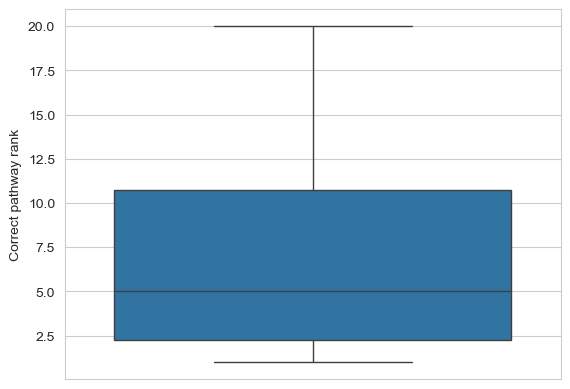

In [5]:
sns.boxplot(data=result_df['Correct pathway rank'])
print('Median rank: ', result_df['Correct pathway rank'].median())
print('Precision@10: ', apk(result_df['Correct pathway rank'])[0])
print('Average Precision@10: ', apk(result_df['Correct pathway rank'])[1])

<AxesSubplot: xlabel='Correct pathway rank', ylabel='Percent'>

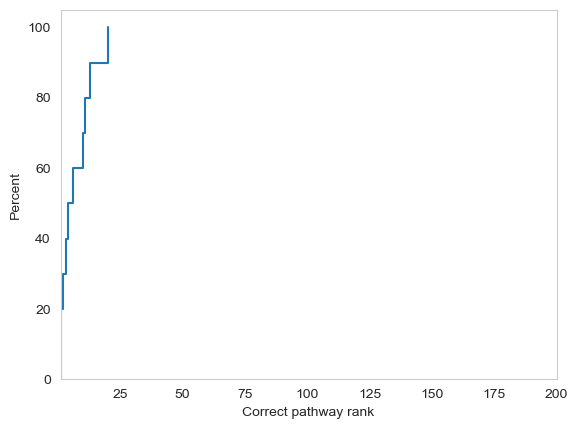

In [6]:
plt.grid(False)
plt.xlim(1, 200)
# plt.ylim(0, 100)
sns.ecdfplot(data=result_df['Correct pathway rank'], stat='percent')